# Extracting waterline vectors from Planet

**Author:** Robbi Bishop-Taylor, Geoscience Australia

---

This takes mosaiced PlanetScope layers (generated using `mosaic_planet.ipynb`), uses Dask to import them as an xarray dataset, then extracts subpixel resolution waterline vectors for each timestep using the algorithm from [Bishop-Taylor et al. 2019](https://doi.org/10.3390/rs11242984).

In [1]:
import os
import sys
import glob
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt


In [2]:
# !pip install --extra-index-url="https://packages.dea.ga.gov.au" git+https://github.com/GeoscienceAustralia/dea-notebooks.git#subdirectory=Tools

In [3]:
from dea_tools.spatial import subpixel_contours

## Lazily load PlanetScope data as an xarray dataset using Dask
Dask allows us to 'lazily' load the mosaiced rasters from file without actually loading them into memory. This is fast, and allows you to then actually import only a specific portion of the resulting xarray.

In [4]:
def time_index_from_filenames(filenames, string_slice=slice(0, 10)):
    '''
    Helper function to generate a Pandas datetimeindex object
    from dates contained in a file path string
    '''
    
    date_strings = [os.path.basename(i)[string_slice] for i in filenames]
    
    return pd.to_datetime(date_strings)

# Get file paths and obtain list of dates from file
mosaic_list = sorted(glob.glob('data/planetscope/mosaics/*_planetscope.tif'))

# Import data and create xarray dask array labelled by timestamps from files
time_var = xr.Variable('time', time_index_from_filenames(mosaic_list, string_slice=slice(0, 8)))
chunks = {'x': 1452, 'y': 1839, 'band': 1}
concat_arrays = xr.concat([xr.open_rasterio(i, chunks=chunks) for i in mosaic_list], dim=time_var)

# Convert to dataset and set band names
concat_ds = concat_arrays.to_dataset(dim='band')
concat_ds = concat_ds.rename({1: 'blue', 2: 'green', 3: 'red', 4: 'nir'})
concat_ds = concat_ds.sortby('time')
concat_ds


<xarray.Dataset>
Dimensions:  (time: 227, x: 1452, y: 1839)
Coordinates:
  * y        (y) float64 6.741e+06 6.741e+06 6.741e+06 ... 6.735e+06 6.735e+06
  * x        (x) float64 2.128e+05 2.128e+05 2.128e+05 ... 2.172e+05 2.172e+05
  * time     (time) datetime64[ns] 2017-03-11 2017-03-20 ... 2018-06-26
Data variables:
    blue     (time, y, x) uint16 dask.array<chunksize=(1, 1839, 1452), meta=np.ndarray>
    green    (time, y, x) uint16 dask.array<chunksize=(1, 1839, 1452), meta=np.ndarray>
    red      (time, y, x) uint16 dask.array<chunksize=(1, 1839, 1452), meta=np.ndarray>
    nir      (time, y, x) uint16 dask.array<chunksize=(1, 1839, 1452), meta=np.ndarray>
Attributes:
    transform:      (3.0, 0.0, 212838.0, 0.0, -3.0, 6740733.0)
    crs:            +init=epsg:32756
    res:            (3.0, 3.0)
    is_tiled:       0
    nodatavals:     (0.0, 0.0, 0.0, 0.0)
    scales:         (1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:  Area

## Import data using Dask's compute
PlanetScope data is very large and memory intensive. For a quick example, here we use Dask to load only a sample of the data with a minimum proportion of valid pixels:

In [5]:
# Give a list of time indices to load
# time_slice = slice('2017-11-01', '2018-02-28')
x_slice = slice(214700, 215420)
y_slice = slice(6740400, 6739600)

# Set 0 values to nodata
concat_ds = concat_ds.where(concat_ds != 0)

# # Keep only obs with a min percentage of good data
subset_ds = concat_ds.sel(#time=time_slice, 
                          x=x_slice, 
                          y=y_slice)
to_keep = subset_ds.nir.isnull().mean(dim=['x', 'y']) < 0.2
subset_ds = subset_ds.sel(time=to_keep)
subset_ds = subset_ds.compute()
subset_ds

<xarray.Dataset>
Dimensions:  (time: 179, x: 240, y: 267)
Coordinates:
  * y        (y) float64 6.74e+06 6.74e+06 6.74e+06 ... 6.74e+06 6.74e+06
  * x        (x) float64 2.147e+05 2.147e+05 2.147e+05 ... 2.154e+05 2.154e+05
  * time     (time) datetime64[ns] 2017-03-24 2017-03-26 ... 2018-06-26
Data variables:
    blue     (time, y, x) float64 792.0 808.0 846.0 844.0 ... 907.0 884.0 904.0
    green    (time, y, x) float64 1.023e+03 1.013e+03 1.024e+03 ... 968.0 988.0
    red      (time, y, x) float64 1.329e+03 1.334e+03 ... 1.155e+03 1.16e+03
    nir      (time, y, x) float64 2.02e+03 2.023e+03 ... 1.529e+03 1.542e+03
Attributes:
    transform:      (3.0, 0.0, 212838.0, 0.0, -3.0, 6740733.0)
    crs:            +init=epsg:32756
    res:            (3.0, 3.0)
    is_tiled:       0
    nodatavals:     (0.0, 0.0, 0.0, 0.0)
    scales:         (1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:  Area

### Compute NDWI

In [6]:
ndwi = (subset_ds.green - subset_ds.nir) / (subset_ds.green + subset_ds.nir)

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


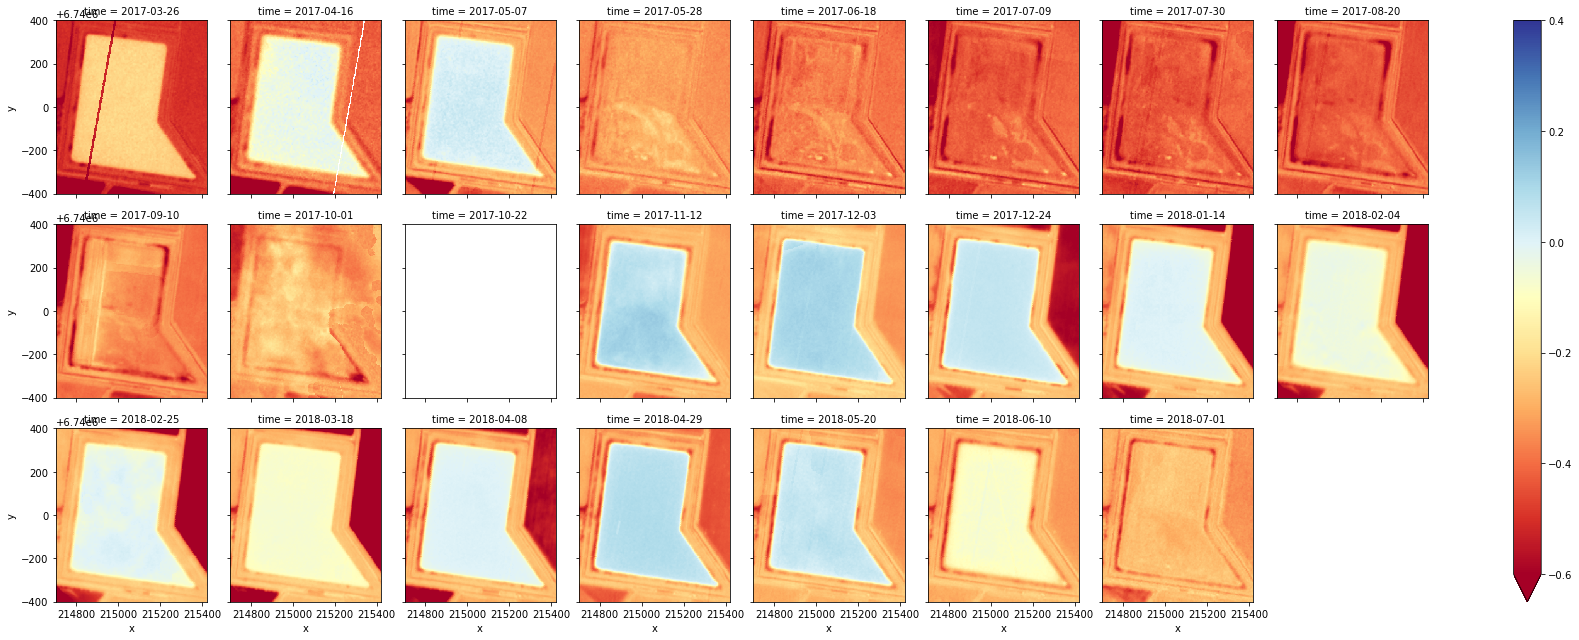

In [7]:
# Resample to median composites
ndwi = ndwi.resample(time='3W').mean()
ndwi.plot(col='time', col_wrap=8, vmin=-0.6, vmax=0.4, cmap='RdYlBu')

### Calculate area over time

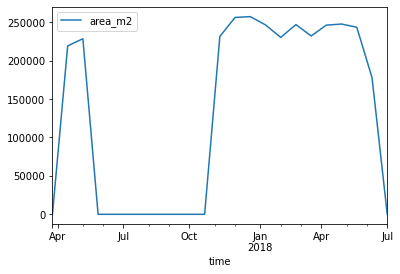

In [8]:
ndwi_threshold = -0.1

# Compute area value
area = (ndwi > ndwi_threshold).sum(dim=['x', 'y']) * (3 * 3)
area_df = area.to_dataframe(name='area_m2')  #.reset_index(drop=True)

# Plot area over time
area_df.plot()

## Extract waterlines
Extract subpixel waterlines according to [Bishop-Taylor et al. 2019](https://doi.org/10.3390/rs11242984):

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


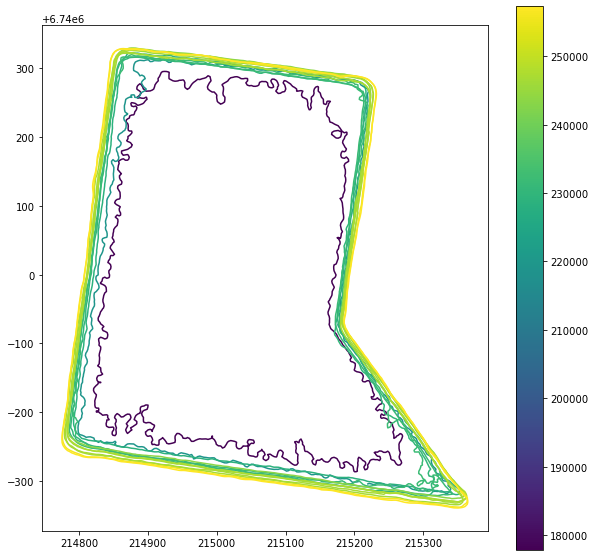

In [9]:
waterlines_gdf = subpixel_contours(ndwi, 
                                   z_values=[ndwi_threshold],
                                   crs=subset_ds.crs, 
                                   affine=subset_ds.affine,
                                   output_path='waterlines.geojson',
                                   attribute_df=area_df.reset_index(drop=True),
                                   min_vertices=100)

# Plot by area
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
waterlines_gdf.sort_values('area_m2').plot(ax=ax, column='area_m2', legend=True)